<a href="https://colab.research.google.com/github/jcestevezc/Machine-Learning-Techniques/blob/master/Laboratorio%204/Laboratorio_IV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


<img src="https://cursos.virtual.uniandes.edu.co/isis4219/wp-content/uploads/sites/162/2014/11/cropped-misisheader.png" ><br>
# Machine Learning Techniques - ISIS4219

Intersemestral 2020




## Objetivos

*   Analizar conjutos de datos no estructurados
*   Aplicar diferentes técnicas de pre-procesamiento de textos.
*   Identificar el mejor modelo para un problema desbalanceado.



## Primer Problema
<p style="text-align: justify;"> El departamento de TI ha desarrollado un servidor de correo para brindar a todos los empleados una cuenta propia donde puedan manejar la información de la empresa. Sin embargo, debido al mal manejo de la cuenta y la falta de capacitación, los directivos se han dado cuenta que a los servidores están llegando varios mensajes <i>Spam</i> que pueden comprometer la seguridad de la información. Para eso, les han pedido construir un sistema el cual permita clasificar y descartar un mensaje <i>Spam</i> antes que llegue a los servidores. <br> Debido a que es un problema reciente y los directivos quieren actuar rápido le han brindado el siguiente archivo con los datos que lograron etiquetar, y les sugieren que utilicen los clasificadores de <i>Näive Bayes</i> y <i>Ensemblers</i>, ya que han escuchado que son muy buenos.</p>


### 1. Importando las librerias requeridas para el desarrollo del laboratorio


Para la transformación de los datos, así como para el entrenamiento de los modelos y la visualización de los resultados, se importan las siguientes librerías:


**Nota:** Para asegurarse de tener las últimas versiones y todos los paquetes instalados que por lo general no vienen en Google Colab. pueden ejecutar la sigiuente celda.

In [1]:
!pip install https://github.com/pandas-profiling/pandas-profiling/archive/master.zip
!pip install contractions
import nltk
nltk.download()

  Using cached https://github.com/pandas-profiling/pandas-profiling/archive/master.zip
  Created wheel for pandas-profiling: filename=pandas_profiling-2.8.0-py2.py3-none-any.whl size=259932 sha256=408fa21b9471115f008b6dc00589ce3b63e6b06a6b71bf960c0a22a7953a7957
  Stored in directory: /tmp/pip-ephem-wheel-cache-vey8i_vb/wheels/56/c2/dd/8d945b0443c35df7d5f62fa9e9ae105a2d8b286302b92e0109
Successfully built pandas-profiling
NLTK Downloader
---------------------------------------------------------------------------
    d) Download   l) List    u) Update   c) Config   h) Help   q) Quit
---------------------------------------------------------------------------
Downloader> d

Download which package (l=list; x=cancel)?
  Identifier> all
       | 
       | Downloading package abc to /root/nltk_data...
       |   Package abc is already up-to-date!
       | Downloading package alpino to /root/nltk_data...
       |   Package alpino is already up-to-date!
       | Downloading package biocreative_pp

True

In [2]:
import pandas as pd
import numpy as np
import sys
from pandas_profiling import ProfileReport

import re, string, unicodedata
import contractions
import inflect
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer

from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import classification_report, confusion_matrix, plot_precision_recall_curve

import matplotlib.pyplot as plt


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### 2. Perfilamiento y entendimiento de los datos



#### Lectura de los datos
Primero, se leen los datos y se visualizan que se hayan leido correctamente.

In [3]:
url = 'https://raw.githubusercontent.com/jcestevezc/Machine-Learning-Techniques/master/Laboratorio%204/Punto%201/SPAM%20text%20message%2020170820%20-%20Data.csv'
data = pd.read_csv(url)
data.head()

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


#### Entendimiento de los Datos

Para entender los mensajes, se realizan 'estadísticas descriptivas' para poder obtener un análisis de los textos.

In [4]:
textos = data.copy()
textos['Conteo'] = [len(x) for x in textos['Message']]
textos['Moda'] = [max(set(x.split(' ')), key = x.split(' ').count) for x in textos['Message']]
textos['Max'] = [[max([len(x) for x in i.split(' ')])][0] for i in textos['Message']]
textos['Min'] = [[min([len(x) for x in i.split(' ')])][0] for i in textos['Message']]

ProfileReport(textos)

### 3. Preparación de datos

Para poder realizar el pre-procesamiento de los datos, es recomendable pasar por tres etapas:
* Eliminación del Ruido.
* Tokenización.
* Normalización.

Para mayor información, pueden consultar el [siguiente artículo](https://medium.com/datos-y-ciencia/preprocesamiento-de-datos-de-texto-un-tutorial-en-python-5db5620f1767
).

#### **3.1 Eliminación del Ruido**
La eliminación del ruido se utiliza para dejar el archivo en texto plano, sobre todo cuando vienen de diferentes fuentes como HTML, Twitter, XML, entre otros. También para eliminar caracteres especiales y pasar todo a minúscula.

In [5]:
def remove_non_ascii(words):
    """Remove non-ASCII characters from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    return new_words

def to_lowercase(words):
    """Convert all characters to lowercase from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = word.lower()
        new_words.append(new_word)
    return new_words

def remove_punctuation(words):
    """Remove punctuation from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

def replace_numbers(words):
    """Replace all interger occurrences in list of tokenized words with textual representation"""
    p = inflect.engine()
    new_words = []
    for word in words:
        if word.isdigit():
            new_word = p.number_to_words(word)
            new_words.append(new_word)
        else:
            new_words.append(word)
    return new_words

def remove_stopwords(words):
    """Remove stop words from list of tokenized words"""
    new_words = []
    for word in words:
        if word not in stopwords.words('english'):
            new_words.append(word)
    return new_words

def preproccesing(words):
    words = to_lowercase(words)
    words = replace_numbers(words)
    words = remove_punctuation(words)
    words = remove_non_ascii(words)
    words = remove_stopwords(words)
    return words

#### **3.2 Tokenización**
La tokenización permite dividir frases u oraciones en palabras. Con el fin de desglozar las palabras correctamente para el posterior análisis. Pero primero, se realiza una corrección de las contracciones que pueden estar presentes en los textos. 

In [6]:
data['Message'] = data['Message'].apply(contractions.fix) #Aplica la corrección de las contracciones

In [7]:
data['words'] = data['Message'].apply(word_tokenize)
data['words'] = data['words'].apply(preproccesing) #Aplica la eliminación del ruido
data.head()

,Category,Message,words
0,ham,"Go until jurong point, crazy.. Available only ...","[go, jurong, point, crazy, available, bugis, n..."
1,ham,Ok lar... Joking wif you oni...,"[ok, lar, joking, wif, oni]"
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,"[free, entry, two, wkly, comp, win, fa, cup, f..."
3,ham,you dun say so early hor... you c already then...,"[dun, say, early, hor, c, already, say]"
4,ham,"Nah I do not think he goes to usf, he lives ar...","[nah, think, goes, usf, lives, around, though]"


#### **Normalización**
Para la normalización de los datos se realiza una eliminación de prefijos y sufijos, además de realizar una lemmatización de los verbos.

In [8]:
def stem_words(words):
    """Stem words in list of tokenized words"""
    stemmer = LancasterStemmer()
    stems = []
    for word in words:
        stem = stemmer.stem(word)
        stems.append(stem)
    return stems

def lemmatize_verbs(words):
    """Lemmatize verbs in list of tokenized words"""
    lemmatizer = WordNetLemmatizer()
    lemmas = []
    for word in words:
        lemma = lemmatizer.lemmatize(word, pos='v')
        lemmas.append(lemma)
    return lemmas

def stem_and_lemmatize(words):
    stems = stem_words(words)
    lemmas = lemmatize_verbs(words)
    return stems + lemmas

data['words'] = data['words'].apply(stem_and_lemmatize) #Aplica lematización y Eliminación de Prefijos y Sufijos.
data.head()

,Category,Message,words
0,ham,"Go until jurong point, crazy.. Available only ...","[go, jurong, point, crazy, avail, bug, n, gre,..."
1,ham,Ok lar... Joking wif you oni...,"[ok, lar, jok, wif, on, ok, lar, joke, wif, oni]"
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,"[fre, entry, two, wkly, comp, win, fa, cup, fi..."
3,ham,you dun say so early hor... you c already then...,"[dun, say, ear, hor, c, already, say, dun, say..."
4,ham,"Nah I do not think he goes to usf, he lives ar...","[nah, think, goe, usf, liv, around, though, na..."


##### **3.4 Selección de campos**

Primero, se separa la variable predictora y los textos que se van a utilizar.

In [9]:
data['words'] = data['words'].apply(lambda x: ' '.join(map(str, x)))
data

,Category,Message,words
0,ham,"Go until jurong point, crazy.. Available only ...",go jurong point crazy avail bug n gre world la...
1,ham,Ok lar... Joking wif you oni...,ok lar jok wif on ok lar joke wif oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,fre entry two wkly comp win fa cup fin tkts 21...
3,ham,you dun say so early hor... you c already then...,dun say ear hor c already say dun say early ho...
4,ham,"Nah I do not think he goes to usf, he lives ar...",nah think goe usf liv around though nah think ...
...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact y...,2nd tim tri two contact 750 pound priz two cla...
5568,ham,Will ü b going to esplanade fr home?,u b going esplanad fr hom u b go esplanade fr ...
5569,ham,"Pity, * was in mood for that. So...any other s...",pity mood suggest pity mood suggestions
5570,ham,The guy did some bitching but I acted like I w...,guy bitch act lik would interest buy someth el...


In [10]:
X, y = data['words'],data['Category']
y = (y == 'spam').astype(int)
y

0       0
1       0
2       1
3       0
4       0
       ..
5567    1
5568    0
5569    0
5570    0
5571    0
Name: Category, Length: 5572, dtype: int64

Primero, se transforma el texto con una transformación binaria 1 a 1.

In [11]:
np.set_printoptions(threshold=sys.maxsize)
dummy = CountVectorizer(binary=True)
X_dummy = dummy.fit_transform(X)
print(X_dummy.shape)
X_dummy.toarray()[0]

(5572, 10047)


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

También, se puede realizar el conteo de las palabras presentes.

In [12]:
count = CountVectorizer()
X_count = count.fit_transform(X)
print(X_count.shape)
X_count.toarray()[0]

(5572, 10047)


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

O, se puede realizar la transformación Term-frecuency times inverse Document-frecuency.

In [13]:
tf_idf = TfidfVectorizer()
X_tf_idf = tf_idf.fit_transform(X)
print(X_tf_idf.shape)
X_tf_idf.toarray()[0]

(5572, 10047)


array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

### 4. Modelamiento

#### **Näive Bayes**

El algoritmo de Näive Bayes es un clasificador estadístico basado en el teorema de Bayes. 

**Dado:**

> $A: $ Eventos mutuamente exclusivos y exhaustivos (estados). <br>
$E: $ Evento observado.

El teorema establece:

$P(A_i|E) = \frac{P(E|A_i)P(A_i)}{P(E)}$

Basado en los datos que se le proporciona, estima la probabilidad que una instancia pertenezca a cada una de las clases. Y con la mayor probabilidad encontrada, asigna el valor de la clase. 

Existen tres tipos de calsificadores Bayes:

*   Bayes Ingenuo.
*   Bayes ingenuo Bernoulli (para atributos binarios).
*   Bayes ingenuo multinomial (para características discretas).

Para este caso, se utilizará el Bayes ingenuo Bernoulli.


In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=33)

estimators = [('transform', CountVectorizer(stop_words='english')), ('clf', BernoulliNB())]
pipe = Pipeline(estimators)

NB = pipe.fit(X_train,y_train)
NB

Pipeline(memory=None,
         steps=[('transform',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words='english', strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('clf',
                 BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None,
                             fit_prior=True))],
         verbose=False)

#### **Ensemblers**

* Combinan una serie de modelos para mejorar el rendimiento de
clasificación.

* Regla para combinar las predicciones de los diferentes clasificadores y producir una única salida.

* Existen diferentes modelos como Bagging, Random Forest, Adaboost, entre otros.

Para determinar el mejor modelo, se van a utilizar los tres algoritmos y se probarán con los diferentes tipos de preprocesamiento.

In [15]:
estimators = [('transform', CountVectorizer(stop_words='english')), 
              ('clf', BaggingClassifier(base_estimator=SVC(kernel='rbf'), random_state=0))]
pipe = Pipeline(estimators)
param_grid = dict(transform=[TfidfVectorizer(stop_words='english'), CountVectorizer(stop_words='english'), HashingVectorizer(stop_words='english',n_features=2**13)],
                  clf = [RandomForestClassifier(random_state=0),
                         BaggingClassifier(base_estimator=SVC(kernel='rbf'), random_state=0),
                         AdaBoostClassifier(random_state=0)],
                  clf__n_estimators=[10,20,50],
                  )
grid_search_EN = GridSearchCV(pipe, param_grid=param_grid,verbose = 20,n_jobs=-1,error_score=0.0)
grid_search_EN.fit(X_train,y_train)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed:   

GridSearchCV(cv=None, error_score=0.0,
             estimator=Pipeline(memory=None,
                                steps=[('transform',
                                        CountVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.int64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                                    

In [16]:
grid_search_EN.best_estimator_

Pipeline(memory=None,
         steps=[('transform',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words='english', strip_accents=None,
                                 sublinear_tf=False,
                                 token_...
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=None, max_features='auto',
                                        max_leaf_nodes=None, max_samples=None

### **5. Predicción**

#### Näive Bayes

In [17]:
y_pred_NB = NB.predict(X_test)
y_pred_NB

array([0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1,
       0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,

#### Ensemblers

In [18]:
EN = grid_search_EN.best_estimator_
display(X_test[:2])
y_pred_EN = EN.predict(X_test)
y_pred_EN

3538    mmmmm sooooo good wak word morn lov mmmm fuck ...
4487                            good weekend good weekend
Name: words, dtype: object

array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1,
       0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,

### **6. Validación**

Para comparar los dos modelos, se realiza la evaluación en el conjunto de test y se construye la matriz de confusión.

In [19]:
report_NB = classification_report(y_test, y_pred_NB,target_names=['ham','spam'])
report_EN = classification_report(y_test, y_pred_EN,target_names=['ham','spam'])

print("Test Report for Näive Bayes\n", report_NB)
print("Confusion Matrix for Näive Bayes\n", confusion_matrix(y_test, y_pred_NB))
print("Test Report for Ensemblers\n", report_EN)
print("Confusion Matrix for Ensemblers\n", confusion_matrix(y_test, y_pred_EN))

Test Report for Näive Bayes
               precision    recall  f1-score   support

         ham       0.98      1.00      0.99       962
        spam       0.99      0.90      0.94       153

    accuracy                           0.98      1115
   macro avg       0.99      0.95      0.97      1115
weighted avg       0.98      0.98      0.98      1115

Confusion Matrix for Näive Bayes
 [[961   1]
 [ 16 137]]
Test Report for Ensemblers
               precision    recall  f1-score   support

         ham       0.99      1.00      0.99       962
        spam       1.00      0.91      0.95       153

    accuracy                           0.99      1115
   macro avg       0.99      0.95      0.97      1115
weighted avg       0.99      0.99      0.99      1115

Confusion Matrix for Ensemblers
 [[962   0]
 [ 14 139]]


Y las curvas de precisión y sensibilidad para la clase de interés

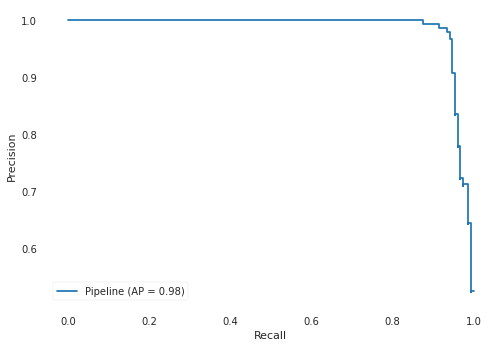

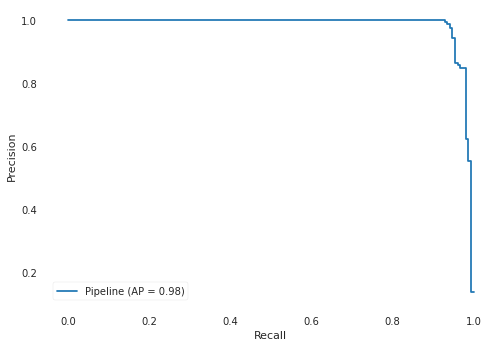

In [20]:
plot_precision_recall_curve(NB, X_test, y_test)
plot_precision_recall_curve(EN, X_test, y_test)


## Taller
## Segundo Problema


Ante la gran demanda de noticias que se generan hoy en día, el servicio público de radio y televisión Británica BBC desea realizar un sistema que le permita clasificar diferentes noticias para mostrarlas en su página web. Para ello, le ha brindado las noticias previamente clasificadas en cinco categorías. <br>
La idea es realizar un clasificador Näive Bayes para la realización de este problema.

In [21]:
import requests
f = requests.get("https://raw.githubusercontent.com/jcestevezc/Machine-Learning-Techniques/master/Laboratorio%204/Punto%202/README.TXT")
print(f.text)

Consists of 2225 documents from the BBC news website corresponding to stories in five topical areas from 2004-2005.
Natural Classes: 5 (business, entertainment, politics, sport, tech)

If you make use of the dataset, please consider citing the publication: 
- D. Greene and P. Cunningham. "Practical Solutions to the Problem of Diagonal Dominance in Kernel Document Clustering", Proc. ICML 2006.

All rights, including copyright, in the content of the original articles are owned by the BBC.

Contact Derek Greene <derek.greene@ucd.ie> for further information.
http://mlg.ucd.ie/datasets/bbc.html


